In [1]:
#this notebook does not account for actions taken between the last step in an episode and first step in subsequent episode
#see physicion_intermediate_acps.ipynb for alternate acp calculation
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
from cost_func import compute_acp_cost, overall_acp_cost, overall_air_cost, compute_map_air
from reward_func import compute_reward_smooth


DATA_PATH = "/abiomed/downsampled/10min_1hr_window.pkl"
N_REWARD_EPISODES = 100
#this is just for the visualization so it isn't messy
MAX_STEPS_TO_PLOT = 2000

In [2]:
with open(DATA_PATH, 'rb') as f:
    data = pickle.load(f)
#this is a check to see what is included in the pkl file and hoow many episodes
print(f"there are {list(data.keys())} keys in dataset")
episodes = data['test']
print(f"episodes: {len(episodes)}")

there are ['train', 'val', 'test', 'mean', 'std'] keys in dataset
episodes: 1266


In [3]:
#to numpy if tensor
if isinstance(episodes, torch.Tensor):    
    episodes_np = episodes.numpy()  
else:
    episodes_np = np.array(episodes)

In [4]:
# the last feature column is action
actions_all = episodes_np[:, :, -1]
states_all = episodes_np[:, :, :-1]
episode_lengths = [len(ep) for ep in actions_all]
episode_boundaries = np.cumsum(episode_lengths)
#at the end of an episode we get episode acp
acp_per_episode = [compute_acp_cost(actions) for actions in actions_all]
#then we get the total mean
acp_per_timestep = overall_acp_cost(actions_all)
air_per_episode_mean = overall_air_cost(actions_all, states_all)
print(f"Mean ACP per episode: {np.mean(acp_per_episode):.6f}")
print(f"Mean ACP per timestep: {acp_per_timestep:.6f}")
print(f"Mean AIR per episode: {air_per_episode_mean:.6f}")

Mean ACP per episode: 0.381517
Mean ACP per timestep: 0.031793
Mean AIR per episode: 0.010049


In [5]:
all_steps_np = np.concatenate(episodes_np, axis=0)
total_steps_available = all_steps_np.shape[0]
print(f"Total timesteps: {total_steps_available}")

# Group the data in bins with 24 steps
episode_length = 24
num_bins = total_steps_available // episode_length
#creates bins and fits the samples into 3D
binned_steps = all_steps_np[:num_bins * episode_length].reshape(num_bins, episode_length, -1)
print(f"Created {num_bins} bins with {episode_length} steps")
# Randomly select 100 of these bins
num_episodes_to_sample = 633
#no replacement
sampled_bin_indices = np.random.choice(num_bins, num_episodes_to_sample, replace=False)

all_episode_rewards = []

# Loop through the 100 randomly selected bins
for bin_idx in sampled_bin_indices:
    # Get one bin
    episode_bin = binned_steps[bin_idx]
    
    normalized_rewards_for_episode = []
    # Loop through each of the 24 steps in the bin
    for step_data in episode_bin:
        step_tensor = torch.tensor(step_data, dtype=torch.float32)
        raw_reward = compute_reward_smooth(step_tensor.unsqueeze(0))
        
        # Apply normalization from rl_env
        norm_reward = (raw_reward + 4) / 5
        clipped_reward = np.clip(norm_reward, -1.0, 1.0)
        normalized_rewards_for_episode.append(clipped_reward)
    
    # Find the total reward for this simulated episode
    total_episode_reward = sum(normalized_rewards_for_episode)
    all_episode_rewards.append(total_episode_reward)

mean_total_episode_reward = np.mean(all_episode_rewards)

print(f"Mean total normalized reward per episode from all bins: {mean_total_episode_reward:.6f}")


Total timesteps: 15192
Created 633 bins with 24 steps
Mean total normalized reward per episode from all bins: -1.770329


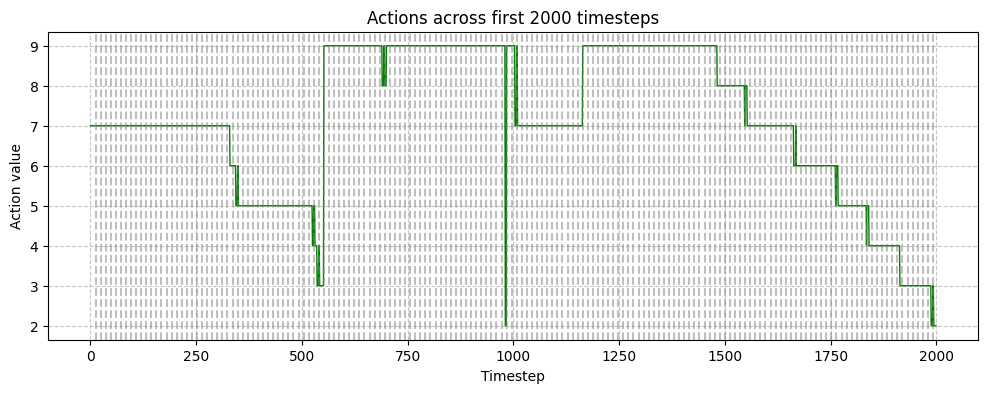

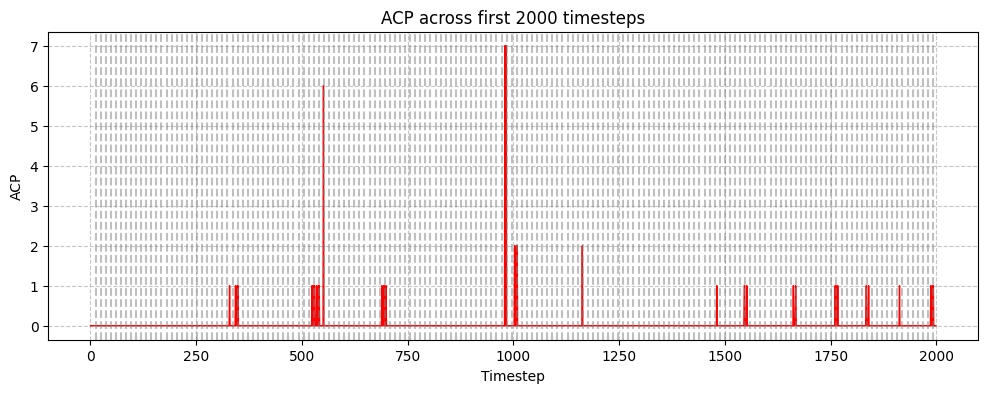

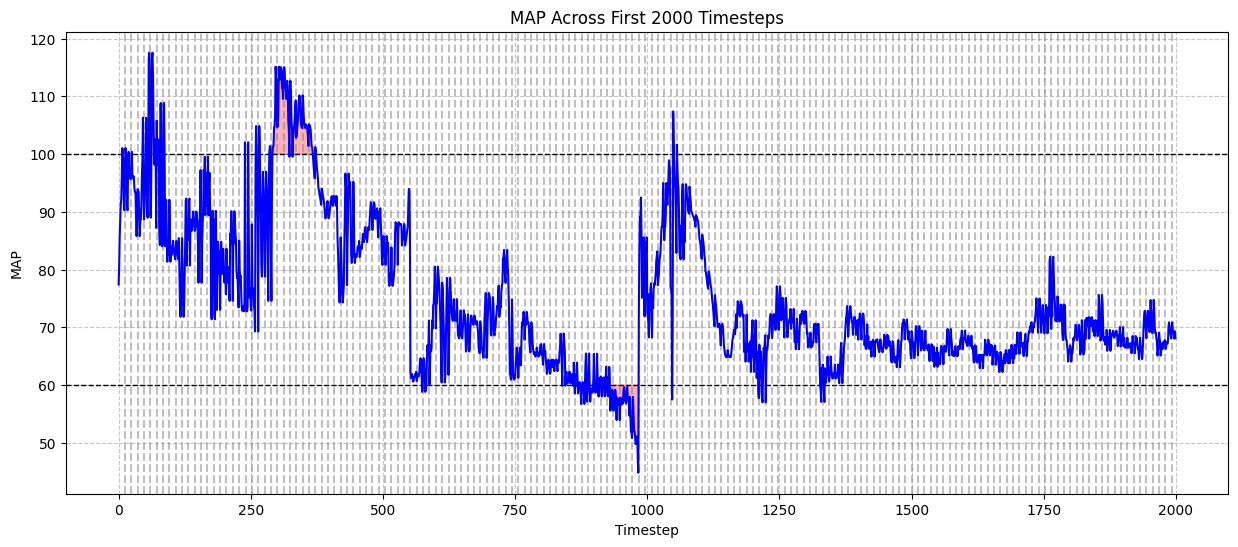

In [6]:
#this is to fill in the missing acp between episodes (wasn't sure if this should be part of mean)
flattened_actions = actions_all.flatten()
flattened_acp = []
prev_action = None
for ep_actions in actions_all:
    for action in ep_actions:
        if prev_action is not None:
            flattened_acp.append(np.linalg.norm(action - prev_action))
        prev_action = action
flattened_acp = np.array(flattened_acp)

#recalculate acp including the change between episodes

flattened_actions = flattened_actions[:MAX_STEPS_TO_PLOT]
flattened_acp = flattened_acp[:MAX_STEPS_TO_PLOT]
episode_boundaries = episode_boundaries[episode_boundaries < MAX_STEPS_TO_PLOT]
flattened_map = all_steps_np[:, 0]
flattened_map = flattened_map[:MAX_STEPS_TO_PLOT]

#action graph over timesteps
#I was getting confused where to check for episode ends so there are vertical lines for those
plt.figure(figsize=(12, 4))
plt.plot(flattened_actions, color='green', linewidth=1)
for boundary in episode_boundaries:
    plt.axvline(boundary, color='gray', linestyle='--', alpha=0.5)
plt.xlabel("Timestep")
plt.ylabel("Action value")
plt.title("Actions across first 2000 timesteps")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

#acp graph over timesteps
plt.figure(figsize=(12, 4))
plt.plot(flattened_acp, color='red', linewidth=1)
for boundary in episode_boundaries:
    plt.axvline(boundary, color='gray', linestyle='--', alpha=0.5)
plt.xlabel("Timestep")
plt.ylabel("ACP")
plt.title("ACP across first 2000 timesteps")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

#map with unsafe regions highlighted
plt.figure(figsize=(15, 6))
timesteps = np.arange(len(flattened_map))
plt.plot(timesteps, flattened_map, color='blue', linewidth=1.5, label='MAP', zorder=5)
plt.fill_between(timesteps, 60, flattened_map, where=flattened_map < 60, 
                 color='red', alpha=0.3, interpolate=True, label='MAP < 60')
plt.fill_between(timesteps, 100, flattened_map, where=flattened_map > 100, 
                 color='red', alpha=0.3, interpolate=True, label='MAP > 100')
plt.axhline(y=60, color='black', linestyle='--', linewidth=1)
plt.axhline(y=100, color='black', linestyle='--', linewidth=1)
for boundary in episode_boundaries:
    plt.axvline(boundary, color='gray', linestyle='--', alpha=0.5)
plt.xlabel("Timestep")
plt.ylabel("MAP")
plt.title("MAP Across First 2000 Timesteps")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

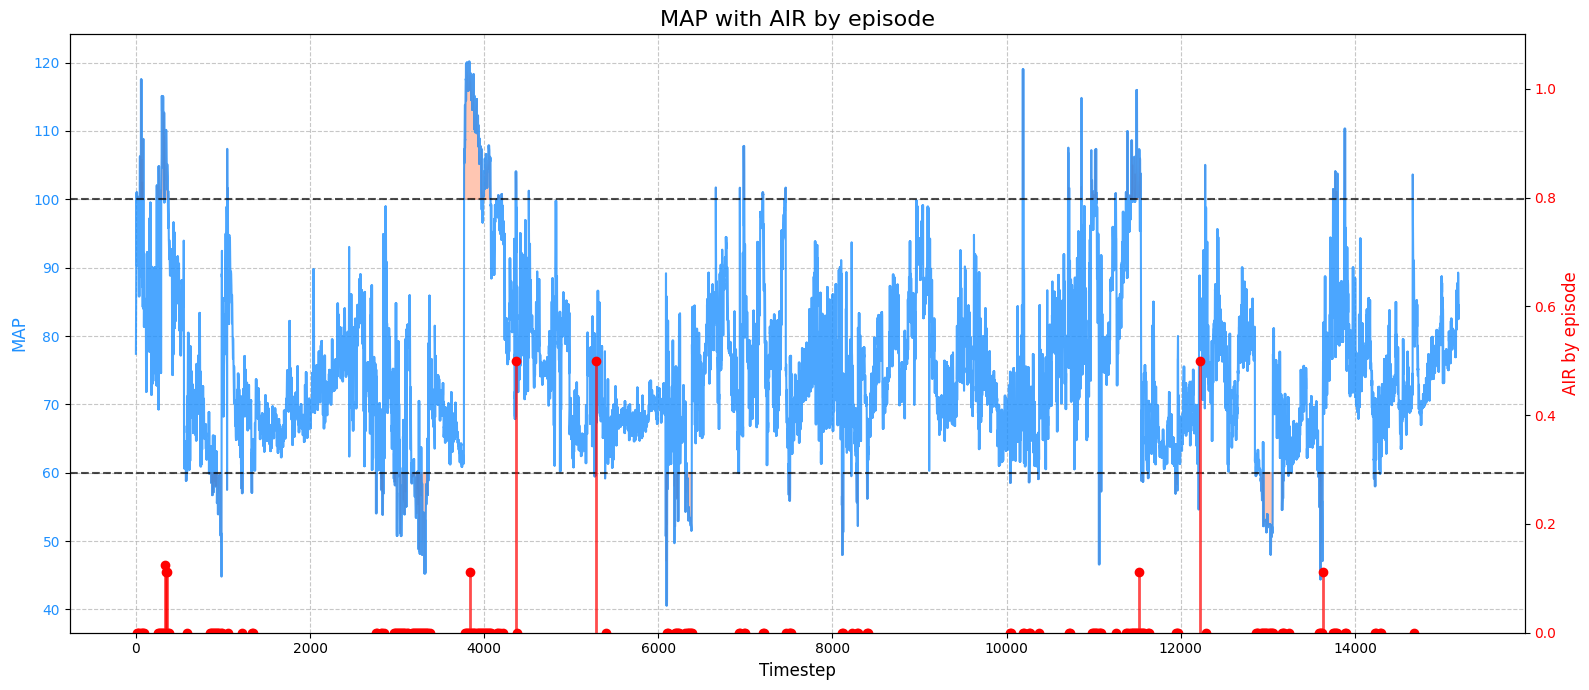

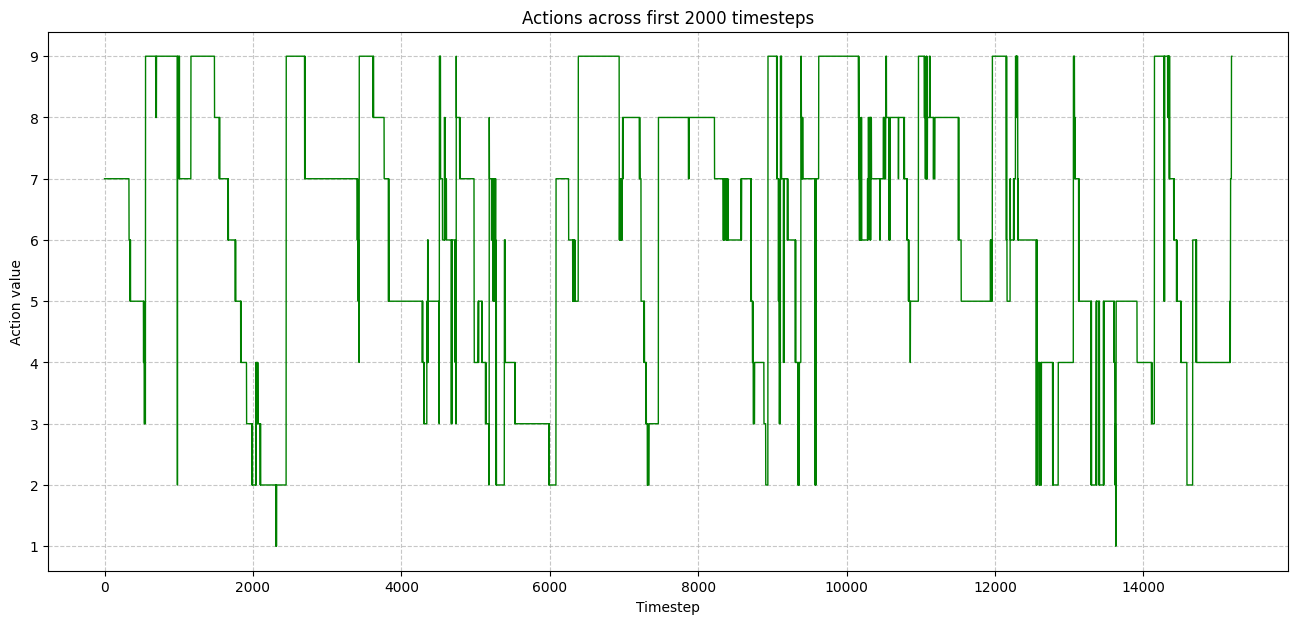

In [7]:
all_episode_rates = []
#the air for each episode
for i in range(len(actions_all)):
    episode_actions = actions_all[i]
    episode_map = states_all[i][:, 0]
    rate = compute_map_air(episode_map, episode_actions)
    all_episode_rates.append(rate)


episode_lengths = [len(ep) for ep in actions_all]
episode_boundaries = np.cumsum(episode_lengths)

#this is just the entire map
full_flattened_map = all_steps_np[:, 0]

fig, ax1 = plt.subplots(figsize=(16, 7))

#the first y axis is the MAP
color = 'dodgerblue'
ax1.set_xlabel('Timestep', fontsize=12)
ax1.set_ylabel('MAP', color=color, fontsize=12)
#i used my full flattened map to get all steps
ax1.plot(full_flattened_map, color=color, label='MAP', alpha=0.8, zorder=2)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, linestyle='--', alpha=0.7)
timesteps = np.arange(len(full_flattened_map))
ax1.axhline(y=60, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
ax1.axhline(y=100, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
ax1.fill_between(timesteps, 60, full_flattened_map, where=full_flattened_map < 60,
                 color='orangered', alpha=0.3, interpolate=True, label='MAP < 60')
ax1.fill_between(timesteps, 100, full_flattened_map, where=full_flattened_map > 100,
                 color='orangered', alpha=0.3, interpolate=True, label='MAP > 100')



#the second y axis is just air
ax2 = ax1.twinx()
color = 'red'
ax2.set_ylabel('AIR by episode', color=color, fontsize=12)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 1.1)

#i got rid of episodes where intensification wasn't needed
valid_rates = []
valid_boundaries = []
for i, rate in enumerate(all_episode_rates):
    if rate is not None:
        valid_rates.append(rate)
        valid_boundaries.append(episode_boundaries[i])

# for air there is a stemplot which honestly could just be dots
markerline, stemlines, baseline = ax2.stem(
    valid_boundaries, 
    valid_rates,
    linefmt='red',
    markerfmt='ro',
    basefmt=' ',
    label='AIR'
)
plt.setp(stemlines, 'linewidth', 2, 'alpha', 0.7)
plt.title('MAP with AIR by episode', fontsize=16)
lines, labels = ax1.get_legend_handles_labels()
fig.tight_layout()
plt.show()
#action graph again
flattened_actions = actions_all.flatten()
plt.figure(figsize=(16, 7))
plt.plot(flattened_actions, color='green', linewidth=1)
plt.xlabel("Timestep")
plt.ylabel("Action value")
plt.title("Actions across first 2000 timesteps")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
